In [12]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2
import seaborn as sb
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten,MaxPooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from sklearn.metrics import confusion_matrix
from keras.models import load_model
from keras import models
from keras.preprocessing import image
from time import time


In [8]:
#Data Preprocessing
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
test_detagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

training_set = train_datagen.flow_from_directory('/home/vineetred/set/English/Img/GoodImg/Bmp/',
                                                 target_size = (32,
                                                 32),
                                                 batch_size = 32,
                                                 color_mode = 'grayscale',
                                                 class_mode =
                                                     'categorical', subset = "training")

validation = train_datagen.flow_from_directory('/home/vineetred/English/Img/GoodImg/Bmp/',
                                                 target_size = (32,
                                                 32),
                                                 batch_size = 1,
                                          
                                                 class_mode = 
                                                     'categorical', color_mode = 'grayscale',subset = 'validation',shuffle=False)

'''
Using the two datasets below just for testing. Ignore them.
'''
collateral = test_detagen.flow_from_directory('/home/vineetred/set/English/Img/GoodImg/Bmp/',
                                                 target_size = (32,
                                                 32),
                                                 batch_size = 32,
                                                 color_mode = 'grayscale',
                                                 class_mode =
                                                     'categorical', subset = "training")

testing_set = test_detagen.flow_from_directory('/home/vineetred/English/Img/GoodImg/Bmp/',
                                                 target_size = (32,
                                                 32),
                                                 batch_size = 1,
                                          
                                                 class_mode = 
                                                     None, color_mode = 'grayscale',subset = 'validation',shuffle=False)

#In case the model does not increase validation
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
                              
                              patience=4,
                              verbose=1, mode='auto')

Found 9399 images belonging to 62 classes.
Found 1899 images belonging to 62 classes.
Found 9399 images belonging to 62 classes.
Found 1899 images belonging to 62 classes.


In [3]:
#My CNN
#Load in case you do not want to train the model again. Make sure to comment everything else out!
# model = load_model('my_model.h5')
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3),activation='relu',input_shape=(32,32,1)))
model.add(MaxPooling2D(pool_size =(2,2), strides = (1,1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size =(2,2), strides = (1,1)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size =(2,2), strides = (1,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size =(2,2), strides = (1,1)))

model.add(Flatten())
model.add(Dropout(0.40))
model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))

model.add(Dense(62,activation="softmax"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 22, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 21, 21, 64)        0         
__________

In [4]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

In [9]:
model.fit_generator(training_set,
                    steps_per_epoch = 299,
                    epochs = 50,
                    validation_data=validation,
                    validation_steps=1899,
                    callbacks=[early_stop, tensorboard],
                    use_multiprocessing = True,
                    workers = 20)


Epoch 1/50
299/299 [==============================] - 56s 188ms/step - loss: 1.8140 - acc: 0.5193 - val_loss: 1.3158 - val_acc: 0.6588
Epoch 2/50
299/299 [==============================] - 56s 186ms/step - loss: 1.2738 - acc: 0.6435 - val_loss: 1.1540 - val_acc: 0.7077
Epoch 3/50
299/299 [==============================] - 56s 187ms/step - loss: 1.0709 - acc: 0.6912 - val_loss: 1.0350 - val_acc: 0.7399
Epoch 4/50
299/299 [==============================] - 57s 189ms/step - loss: 0.9237 - acc: 0.7255 - val_loss: 0.9808 - val_acc: 0.7467
Epoch 5/50
299/299 [==============================] - 56s 187ms/step - loss: 0.8082 - acc: 0.7545 - val_loss: 1.0419 - val_acc: 0.7420
Epoch 6/50
299/299 [==============================] - 56s 187ms/step - loss: 0.7183 - acc: 0.7716 - val_loss: 1.0555 - val_acc: 0.7562
Epoch 7/50
299/299 [==============================] - 56s 189ms/step - loss: 0.6425 - acc: 0.7971 - val_loss: 1.0944 - val_acc: 0.7609
Epoch 8/50
299/299 [==============================] - 5

In [10]:
#TESTING/EVALUATION
model.evaluate_generator(validation, steps = 1899)

[1.0091413944457237, 0.7746182201158505]

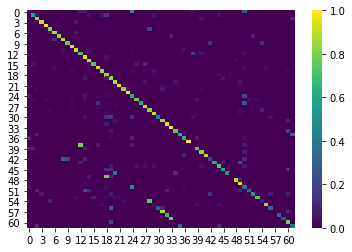

In [23]:
#Confusion Matrix

predictions = model.predict_generator(validation, steps = 1899) #Stores the predictions
predictions = np.argmax(predictions,axis = 1) #Only keeps the most probable class
true_predictions = validation.classes #Stores true classes
cm = confusion_matrix(true_predictions, predictions) #Creates a confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] #Normalises to float
sb.heatmap(cm_normalized,cmap='viridis')

array([8])

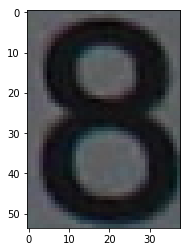

In [15]:
#Predict images classes

img_path = '/home/vineetred/set/English/Img/GoodImg/Bmp/Sample009/img009-00009.png' #Path to the image

#Normalising the image
img_arr = image.load_img(img_path,target_size=(32,32),color_mode='grayscale')
img_arr = image.img_to_array(img_arr)
img_arr /= 255.
img_arr = np.expand_dims(img_arr, axis=0)

 

#Displaying the image
img = plt.imread(img_path)
plt.imshow(img)


model.predict_classes(img_arr)
# Returns a list of five Numpy arrays: one array per layer activation


(1, 19, 19, 64)


/home/vineetred/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


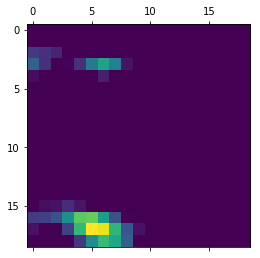

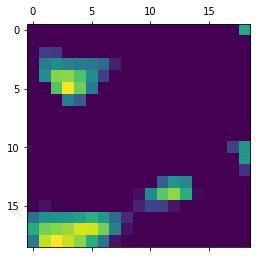

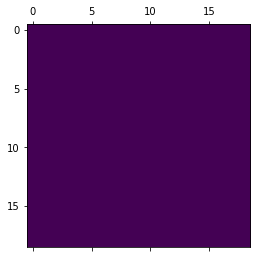

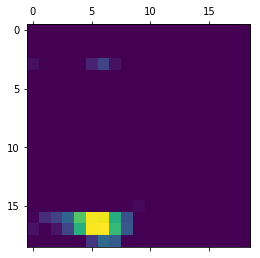

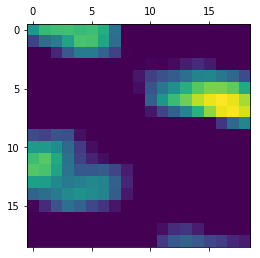

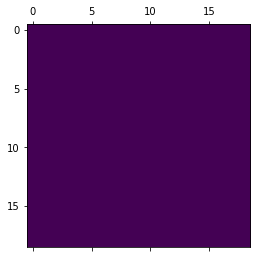

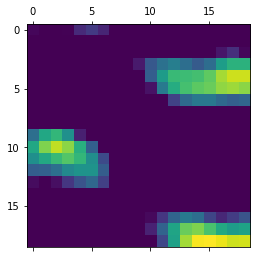

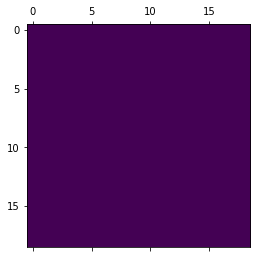

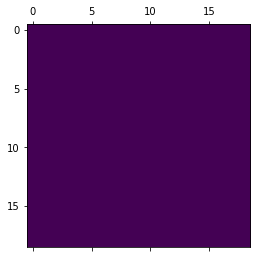

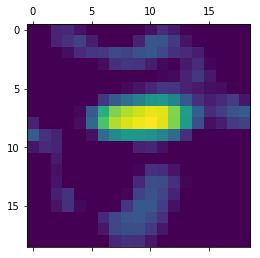

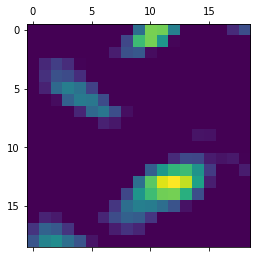

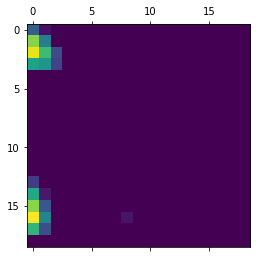

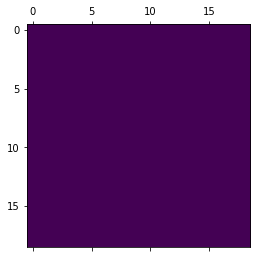

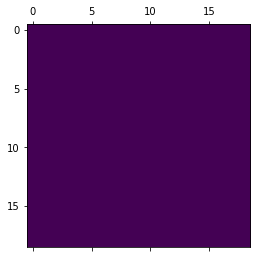

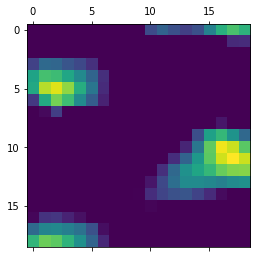

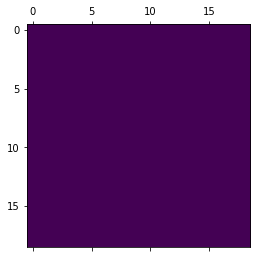

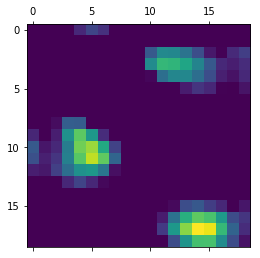

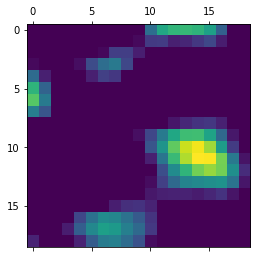

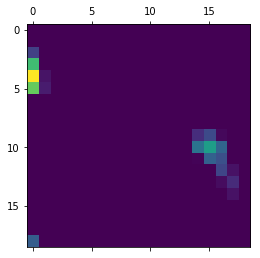

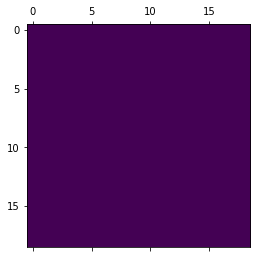

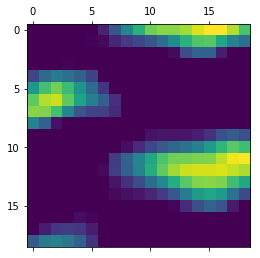

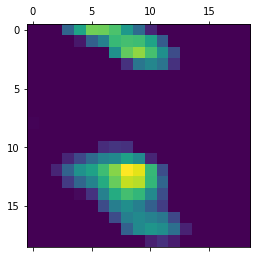

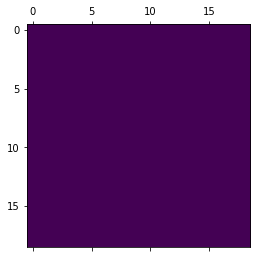

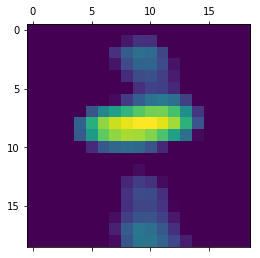

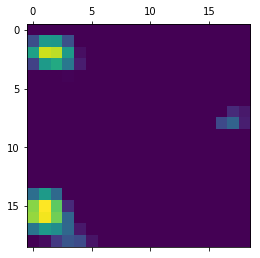

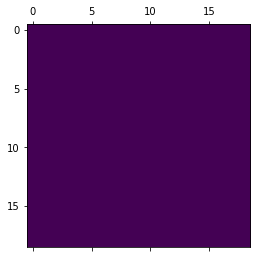

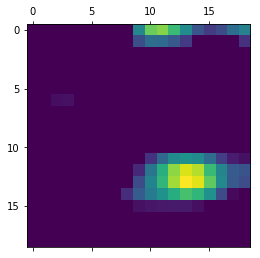

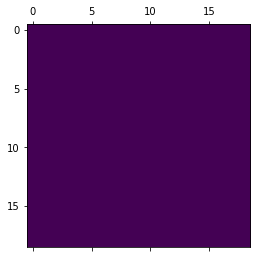

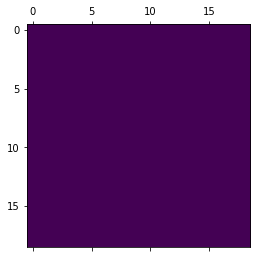

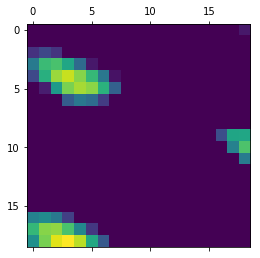

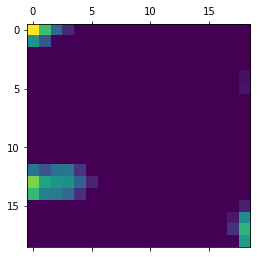

In [ ]:
#Seeing what the convolution layer sees

# Extracts the outputs of the top 12 layers
outputLayers = [layer.output for layer in model.layers[:12]] 

#Passing the image to the conv layer
activation_model = models.Model(inputs=model.input, outputs=outputLayers) 
activations = activation_model.predict(img_arr)

layerNumber = 7 #Define which layer you want to look at
first_layer_activation = activations[layerNumber]

print(first_layer_activation.shape)

for i in range(0,32):
    plt.matshow(first_layer_activation[0, :, :, i], cmap='viridis')
